In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,Layer
from sklearn.utils import shuffle
import seaborn as sns
import keras.utils as image
import glob
from tqdm import tqdm
sns.set()

In [2]:
parent_dir = "D:\JupyterNotebook\BreastCancerDetection\IDC_regular_ps50_idx5"
dir_list = os.listdir(parent_dir)
print(dir_list[:5])


['10253', '10254', '10255', '10256', '10257']


In [3]:
N_IDC, P_IDC = [], [] #This list will contain all the paths to the images. 
#NOTE: Keep in mind whereever I have written negative or positive in this entire notebook, it refers to '0' and '1' respectively.


for dir_name in tqdm(dir_list):
    #For adding negaive paths.
    negative_file_path = os.path.join(parent_dir,dir_name,'0')#will contain path of the negative folders.
    negative_image_names = os.listdir(negative_file_path)
    for negative_image_name in negative_image_names:
        N_IDC.append(os.path.join(parent_dir,dir_name,'0',negative_image_name))
        #or we could have also written it as ...

    
    #For adding positive paths.        
    positive_file_path = os.path.join(parent_dir,dir_name,'1')#will contain path of the positive folders.
    positive_image_names = os.listdir(positive_file_path)#positive_image_names is a list that will hold the names of images...
    #that are inside the folder of '1'
    for positive_image_name in positive_image_names:
        P_IDC.append(os.path.join(parent_dir,dir_name,'1',positive_image_name))


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [00:03<00:00, 85.60it/s]


In [4]:
N_IDC[:5]

['D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png']

In [5]:
P_IDC[:5]

['D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png',
 'D:\\JupyterNotebook\\BreastCancerDetection\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']

In [6]:
print("Number of negative test IDC : "+str(len(N_IDC)))
print("Number of positive test IDC : "+str(len(P_IDC)))

Number of negative test IDC : 198738
Number of positive test IDC : 78786


In [7]:
##Since we know there is a clear imbalance we will crop down the 
##size of the images. The problem is that ideally we should have taken 
##both the sizes as 78,786 for each but we will drop it down even more 
##further because it is throwing memory error for that much amount of 
##data. So, 50,000 sounds good.

##update 1: It is throwing memory error even at 50,000 so dropping it down to 40,000 samples.
##update 2: Same, dropping it to 35,000

In [8]:
NEW_SIZE = 17000

N_IDC = N_IDC[:NEW_SIZE]
P_IDC = P_IDC[:NEW_SIZE]
len(N_IDC)

17000

In [9]:
# Printing random images

In [10]:
random_indicies = np.random.randint(50, NEW_SIZE, 4) #low,high,number of elements
random_indicies

array([ 6810,  4178,  5165, 12047])

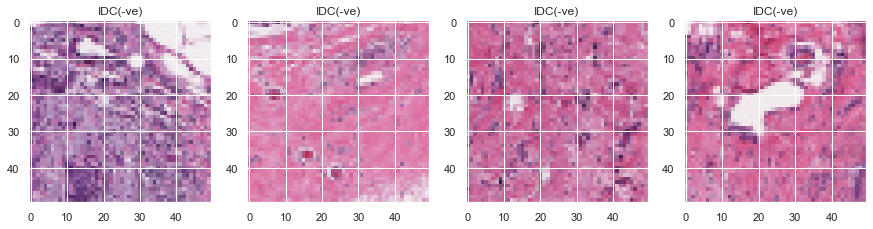

In [11]:
plt.figure(figsize=(15,15))
for i in range(4):
    img = image.load_img(N_IDC[random_indicies[i]])
    plt.subplot(1,4,1+i)
    plt.imshow(img)
    plt.title('IDC(-ve)')

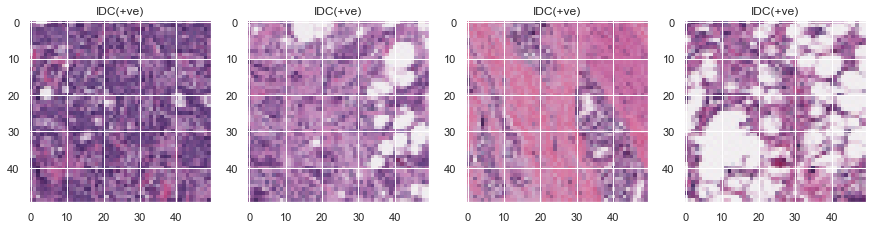

In [12]:
plt.figure(figsize=(15,15))
for i in range(4):
    img = image.load_img(P_IDC[random_indicies[i]])
    plt.subplot(1,4,1+i)
    plt.imshow(img)
    plt.title('IDC(+ve)')

In [13]:
#Now reading the paths of image with cv2 and storing in a np.array format

#Since, the lists N_IDC and P_IDC contains paths,
#So, we will create 2 more empty arrays of fixed dimension that will contain the pixel info in np.array form.
image_N_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)
image_P_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)

#Side by side will create 2 more lists that will contain the list of targets for both.
target_N_IDC, target_P_IDC = [], [] #Firstwill contain only '0's and second with only '1's.

#keep in mind that there a few images inside these folders that are cropped i.e. not of the dimension 50x50.
#So for that we will have to resize ever image. Those who are already of the same size will remain the same but those which..
#are not will change to 50x50x3.

for i,image_path in tqdm(enumerate(N_IDC)):
    image_array = cv2.imread(image_path,cv2.IMREAD_COLOR)#First will have to read the path and store as an image.
    #Only then we can change the shape. We can NOT directly use the .resize() function.
    resized_image_array = cv2.resize(image_array,(50,50),interpolation = cv2.INTER_LINEAR)
    #We will give it the image_array, the desired dimension we want and the method of interpolation.
    #The interpolation part looks complex but actually isn't, we are just specifying a method to change dimensions.
    image_N_IDC[i]=resized_image_array#Notice we are not adding/appending anything here.
    #We updateding the image_N_IDC array and hence toggling through the array with [i]
    target_N_IDC.append(0)
    
#same with posiktive data.
for i,image_path in tqdm(enumerate(P_IDC)):
    image_array = cv2.imread(image_path,cv2.IMREAD_COLOR)#First will have to read the path and store as an image.
    #Only then we can change the shape. We can NOT directly use the .resize() function.
    resized_image_array = cv2.resize(image_array,(50,50),interpolation = cv2.INTER_LINEAR)
    image_P_IDC[i]=resized_image_array#Notice we are not adding/appending anything here.
    #We updateding the image_N_IDC array and hence toggling through the array with [i]
    target_P_IDC.append(1)
    
#This code will take a descent amount of time, be patient.

C:\Users\kunal\AppData\Local\Temp\ipykernel_14592\587124832.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_N_IDC = np.zeros(shape=(len(N_IDC),50,50,3),dtype=np.float)
C:\Users\kunal\AppData\Local\Temp\ipykernel_14592\587124832.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image_P_IDC = np.zeros(shape=(len(N_IDC),50,50,3),

In [14]:
print("image array size for negative: "+str(image_N_IDC.shape))
print("image array size for positve:  "+str(image_P_IDC.shape))

image array size for negative: (17000, 50, 50, 3)
image array size for positve:  (17000, 50, 50, 3)


In [15]:
#We do that with a function called 'concatenate' 
inputs = np.concatenate((image_N_IDC, image_P_IDC), axis = 0)#axis=0 says that added in terms of rows, one below the other.
targets = np.concatenate((target_N_IDC, target_P_IDC), axis = 0)

#This code will take a descent amount of time, be patient.

In [16]:
print("new input image array size: "+str(inputs.shape))
print("new target size:  "+ str(targets.shape))

new input image array size: (34000, 50, 50, 3)
new target size:  (34000,)


In [17]:
inputs ,targets = shuffle(inputs , targets, random_state = 0)#Notice that we call the shuffle function at once...
#simultaniously to maintain the shuffle order with the targets data.

#This code will take a descent amount of time, be patient.

In [18]:
x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.1)
x_train.shape
#This code will take a descent amount of time, be patient.

(30600, 50, 50, 3)

In [19]:
y_train.shape

(30600,)

In [20]:
x_train,x_validation,y_train,y_validation = train_test_split(x_train ,y_train ,test_size=0.2)
x_train.shape

#This code will take a descent amount of time, be patient.

(24480, 50, 50, 3)

In [21]:
x_validation.shape

(6120, 50, 50, 3)

In [22]:
input_size = 50*50*3
output_size = 1  # Since we want to determine +ve or -ve test for IDC

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),  # This is the first hidden layer.

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),  # This is the second hidden layer.

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),  # This is the third hidden layer.4
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 

    tf.keras.layers.Flatten(), #The values and all will be intact of the 4th hidden layer
    
    tf.keras.layers.Dense(256, activation='relu'),  # 5th layer
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128, activation='relu'),  # 5th layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(output_size, activation='sigmoid')  # Final 6th layer
    # our model will predict.
    
])

In [23]:
from keras.optimizers import Adam
Adam = Adam(learning_rate = 0.0001)

model.compile(optimizer=Adam,loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 22, 22, 64)        256       
 chNormalization)                                                
                                                        

In [25]:
NUM_EPOCHS = 50
BATCH_SIZE = 200
#The above are our hyperparamters and we will tune it according to our analysis.

early_stopping = tf.keras.callbacks.EarlyStopping() #Will instantly stop the process if it detects a increase in validation_acc
history = model.fit(x_train,
                    y_train, 
                    epochs=NUM_EPOCHS,
                    validation_data=(x_validation,y_validation),
                    callbacks = [early_stopping],
                    batch_size = BATCH_SIZE,
                    verbose=1)

Epoch 1/50
123/123 [==============================] - 71s 559ms/step - loss: 0.4988 - accuracy: 0.7742 - val_loss: 0.8070 - val_accuracy: 0.5593
Epoch 2/50
123/123 [==============================] - 72s 582ms/step - loss: 0.3755 - accuracy: 0.8382 - val_loss: 0.7594 - val_accuracy: 0.6871
Epoch 3/50
123/123 [==============================] - 71s 577ms/step - loss: 0.3308 - accuracy: 0.8582 - val_loss: 0.5522 - val_accuracy: 0.7694
Epoch 4/50
123/123 [==============================] - 66s 538ms/step - loss: 0.3043 - accuracy: 0.8704 - val_loss: 0.3920 - val_accuracy: 0.8348
Epoch 5/50
123/123 [==============================] - 68s 554ms/step - loss: 0.2783 - accuracy: 0.8823 - val_loss: 0.4234 - val_accuracy: 0.8265


In [39]:
history.history??

Text(0.5, 1.0, 'Loss vs Epochs')

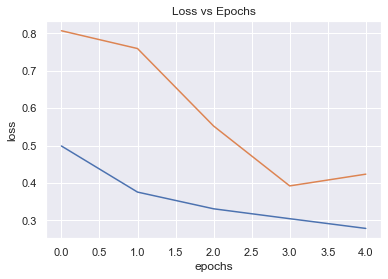

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs Epochs')

In [41]:
print("Training accuracy : "   + str(history.history['accuracy'][3]*100.00)+'%')
print("Validation accuracy : " + str(history.history['val_accuracy'][3]*100.00)+'%')

Training accuracy : 87.04248070716858%
Validation accuracy : 83.48039388656616%


Text(0.5, 1.0, 'Accuracy vs Epochs')

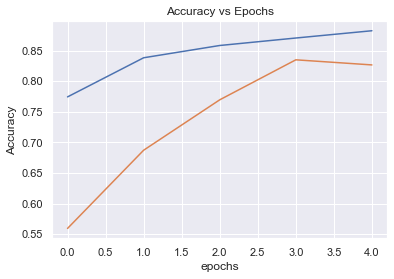

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

In [43]:
test_loss, test_acc = model.evaluate(x_test,y_test)

107/107 [==============================] - 2s 17ms/step - loss: 0.3980 - accuracy: 0.8344


In [44]:
test_loss

0.3979717195034027

In [38]:
print("Test accuracy : " +str(test_acc*100.00))
print("Validation accuracy : " +str(history.history['val_accuracy'][3]*100.00))

Test accuracy : 83.44117403030396
Validation accuracy : 83.48039388656616


107/107 [==============================] - 2s 20ms/step


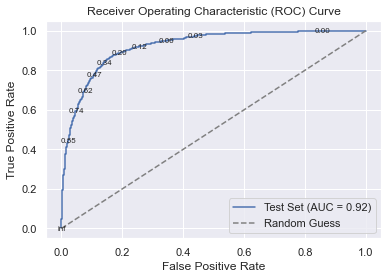

In [52]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    step = len(thresholds) // 10
    for i in range(0, len(thresholds), step):
        plt.text(fpr[i], tpr[i], f'{thresholds[i]:.2f}', fontsize=8, ha='center', va='center')


y_pred_test = model.predict(x_test)
plot_roc_curve(y_test, y_pred_test, 'Test Set')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

plt.grid(True)
plt.legend()
plt.show()

In [53]:
### From the graph we see that we have a threshold of 0.34 (it could be between 0.34 and 0.25, but 0.34 seems much better)

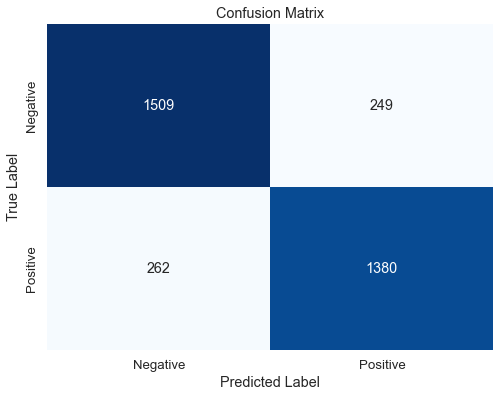

In [55]:
from sklearn.metrics import confusion_matrix

threshold = 0.34
y_pred_binary = (y_pred_test >= threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
